## Summary notes

Select, fit, and check an ARIMA model of a time series.

Data was taken from the Open University's M249, Practical Modern Statistics.

Seasonal fluctuations increased with level, so a logarithmic transformation was used to make an additive model appropriate.
A *seasonally adjusted series* was obtained using *decomposition*, which was made *stationary* using first differences.
StatsModels's `ARIMA`[^1] class was used to model and fit the time series.
The `ARIMA.fit` method returns an instance of `ARIMAResults`.[^2]

A single plausible model **ARIMA**(1, 1, 1) was checked and found to be adequate.

This topic is covered in M249, Book 2, Parts 3.11.

## Dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
from statsmodels import api as sm
from statsmodels.tsa import api as tsa
from statsmodels.graphics import tsaplots
from matplotlib import pyplot as plt
import seaborn as sns
import laughingrook as lr

Set the graphing defaults.
(This is optional.)

In [2]:
sns.set_theme()

## Main

### Load the data

In [3]:
electricity = lr.datasets.get_csv_file('m249/timeseries/electricity.csv')
electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      300 non-null    object 
 1   demand    300 non-null    int64  
 2   sademand  300 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 7.2+ KB


### Initialise and plot the time series

The first observation is in January 1965.

In [4]:
electricity['date'].head(1)

0    Jan-1965
Name: date, dtype: object

Initialise the `Series`.

In [5]:
ts_demand = pd.Series(
    data=electricity['demand'].to_numpy(),
    name='demand',
    index=pd.date_range(
        start='1965-01',
        periods=electricity['demand'].size,
        freq='M',
        name='month'
    )
)
ts_demand.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 300 entries, 1965-01-31 to 1989-12-31
Freq: M
Series name: demand
Non-Null Count  Dtype
--------------  -----
300 non-null    int64
dtypes: int64(1)
memory usage: 4.7 KB


Plot the time series.

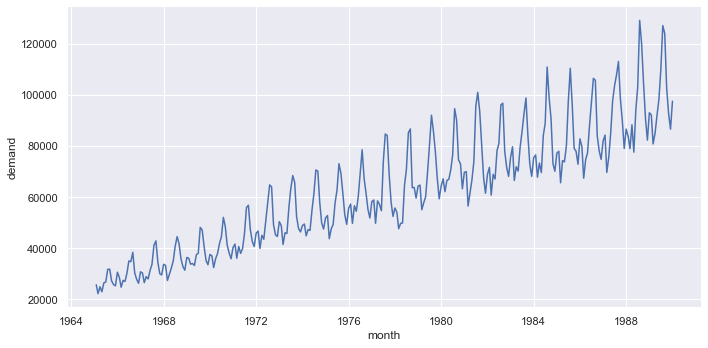

In [6]:
_g = sns.relplot(x=ts_demand.index, y=ts_demand, kind='line', aspect=2)
plt.show()

Transform the time series.

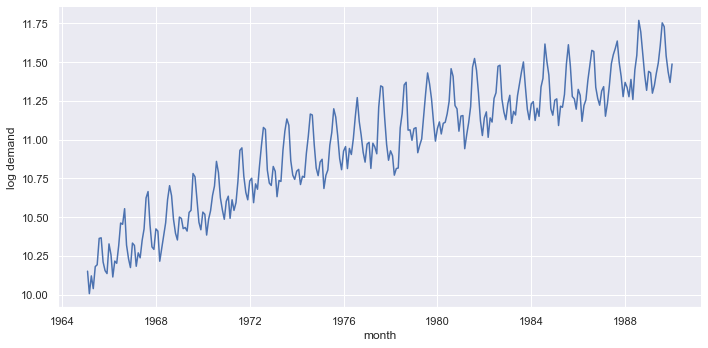

In [7]:
ts_logdemand = ts_demand.map(np.log).rename('log demand')
_g = sns.relplot(x=ts_logdemand.index, y=ts_logdemand, kind='line', aspect=2)
plt.show()

Get the seasonally adjused series.

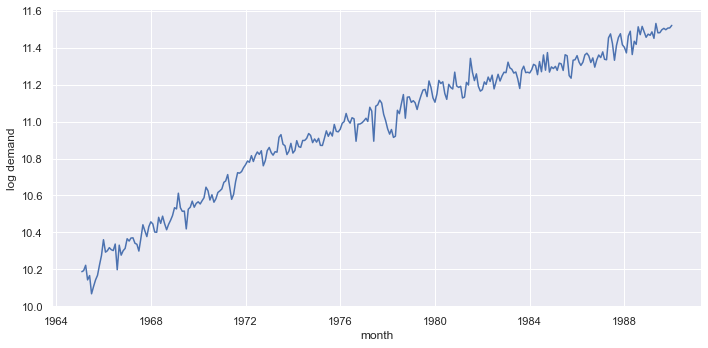

In [8]:
_decomp = tsa.seasonal_decompose(ts_logdemand)
sadjusted = pd.Series(
    data=_decomp.observed - _decomp.seasonal,
    name='log demand'
)
_g = sns.relplot(x=sadjusted.index, y=sadjusted, kind='line', aspect=2)

### Select the model

Difference the time series.

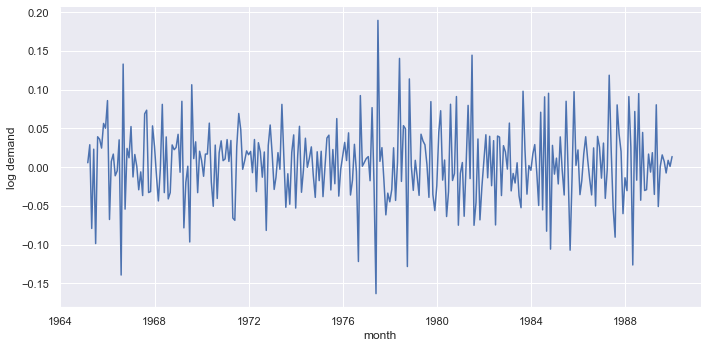

In [9]:
diff1 = sadjusted.diff().dropna()
_g = sns.relplot(x=diff1.index, y=diff1, kind='line', aspect=2)

Plot the sample ACF and PACF.

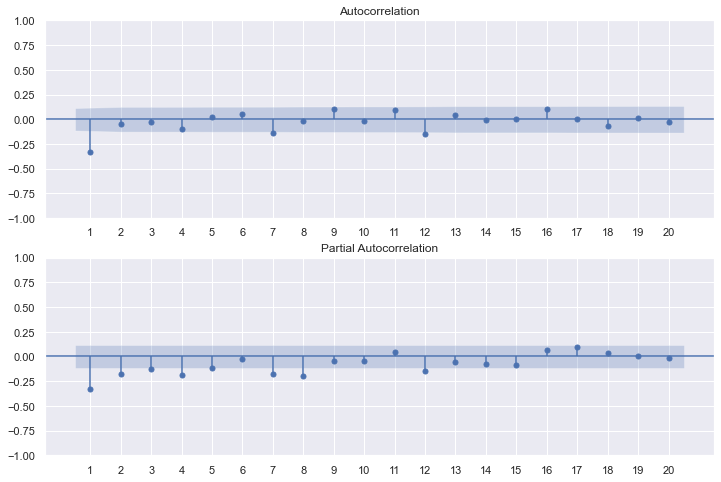

In [10]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(211)
ax1.set_xticks(np.arange(1, 21))
f = tsaplots.plot_acf(diff1, lags=20, zero=False, ax=ax1)
ax2 = f.add_subplot(212)
f = tsaplots.plot_pacf(diff1, lags=20, zero=False, method='ywm', ax=ax2)
ax2.set_xticks(np.arange(1, 21))
plt.show()

### Fit the model

Model and fit the time series.

In [11]:
arima = tsa.ARIMA(sadjusted, order=(1, 1, 1), trend='t')
fitted = arima.fit()

Construct a `DataFrame` holding both the seasonally adjusted and fitted time series.

We perform a *left join*[^3], given *fitted* is missing the initial observation.

In [12]:
all_ts_logdemand = pd.merge(
    left=sadjusted.rename('sadjusted'),
    right=fitted.fittedvalues[1:].rename('fit'),
    left_index=True,
    right_index=True,
    how='left'
)
all_ts_logdemand.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 1965-01-31 to 1989-12-31
Freq: M
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sadjusted  300 non-null    float64
 1   fit        299 non-null    float64
dtypes: float64(2)
memory usage: 7.0 KB


Plot the fitted time series.

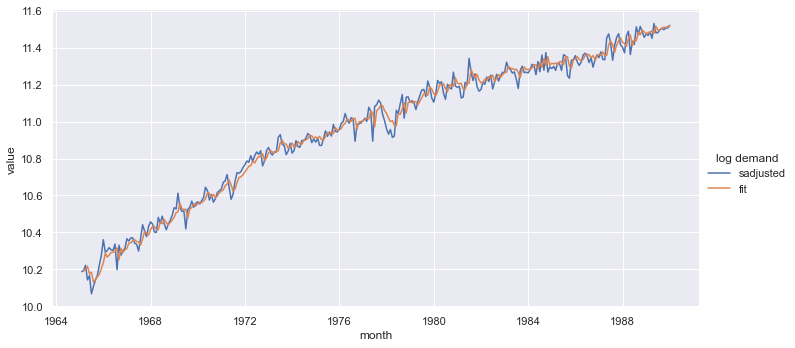

In [13]:
_gsource = all_ts_logdemand.melt(
    var_name='log demand',
    ignore_index=False
).reset_index(
)

_g = sns.relplot(
    data=_gsource,
    x='month',
    y='value',
    hue='log demand',
    kind='line',
    aspect=2
)
plt.show()

Get the fitted model's parameters.

In [14]:
fitted.params

x1        0.004498
ar.L1     0.363633
ma.L1    -0.861967
sigma2    0.001883
dtype: float64

### Check the model

Time series of the residuals.

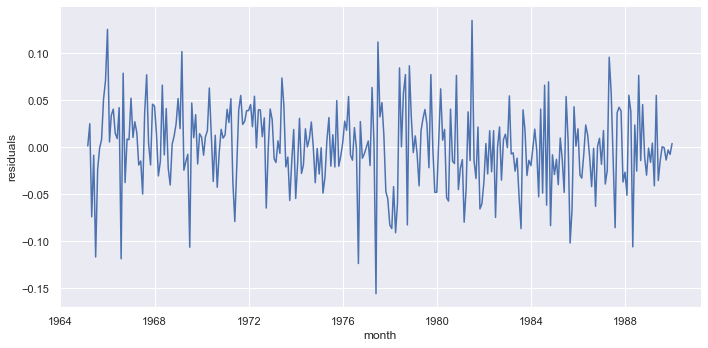

In [15]:
_g = sns.relplot(
    x=fitted.resid.index[1:],
    y=fitted.resid[1:],
    kind='line',
    aspect=2
)
plt.ylabel('residuals')
plt.show()

Plot the in-sample autocorrelations.

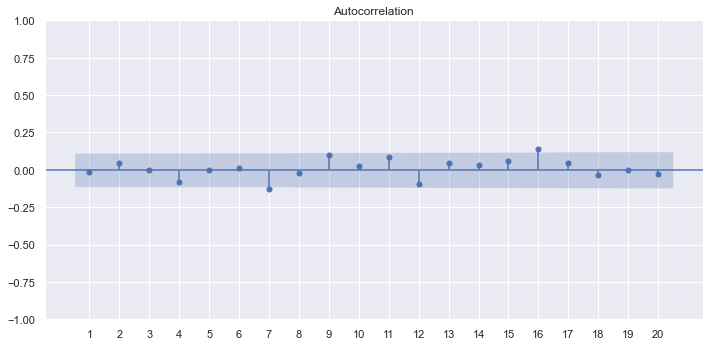

In [16]:
_f, _ax = plt.subplots(figsize=(11.8, 5.5))
tsaplots.plot_acf(fitted.resid[1:], lags=20, zero=False, ax=_ax)
plt.xticks(np.arange(1, 21))
plt.show()

Return the results of a Ljung-Box test.

In [17]:
sm.stats.acorr_ljungbox(fitted.resid[1:], lags=[20])

,lb_stat,lb_pvalue
20,26.009743,0.16549


Plot a histogram of the forecasting errors.

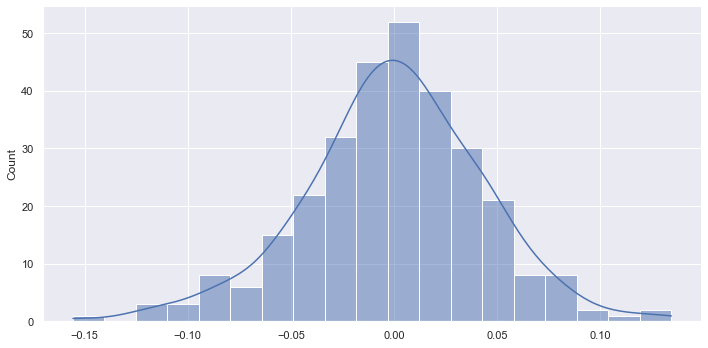

In [18]:
_g = sns.displot(
    x=fitted.resid[1:],
    kind='hist',
    kde=True,
    aspect=2
)
plt.show()

## Forecasting

Plot forecasts for the next 12 months.

The merge is a *full outer join*[^4], given the indices of *all_ts_logdemand* and *_fcast* do not overlap.

We initialise a variable to hold reference to the forecasted values, which we use later on to plot the vertial line separating the *observed*, *fitted* lines from the *forecast* line.

If you think the separator is unnecessary, then *\_fcast* is not needed and the forecast could be moved directly into the `merge` function.

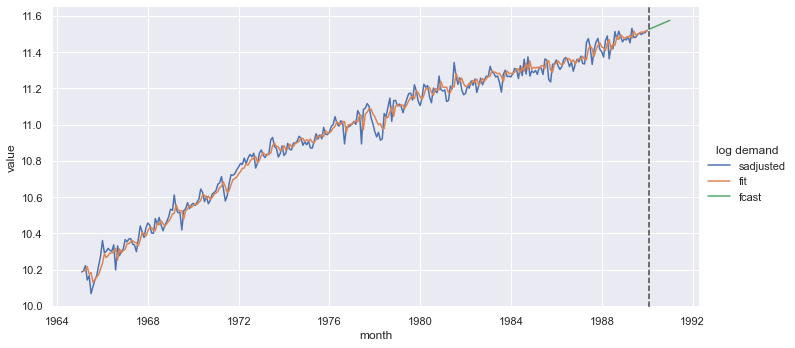

In [19]:
_fcast = fitted.forecast(12)
_gsource = pd.merge(
    left=all_ts_logdemand,
    right=_fcast.rename('fcast'),
    left_index=True,
    right_index=True,
    how='outer'
).rename_axis(
    'month',
    axis=0
).melt(
    var_name='log demand',
    ignore_index=False
).reset_index(
)

_g = sns.relplot(
    data=_gsource,
    x='month',
    y='value',
    hue='log demand',
    kind='line',
    aspect=2
)
plt.axvline(_fcast.index[0], alpha=0.7, ls='--', color='black')
plt.show()

Quantify a forecast.

In [20]:
_fcast = fitted.forecast(1)[0]
_std_err = np.sqrt(
    st.norm().ppf(0.975) * (fitted.sse / fitted.fittedvalues.size)
)
pd.Series(
    data=[_fcast, _fcast - _std_err, _fcast + _std_err],
    index=['pred', 'lpb', 'upb']
)

pred    11.525067
lpb     10.699765
upb     12.350370
dtype: float64

[^1]: See [statsmodels.tsa.arima.model.ARIMA](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html)
[^2]: see [statsmodels.tsa.arima.model.ARIMAResults](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.html)
[^3]: *The **left join*** [....] *returns all rows from the left table whether or not there is a matching row in the right table.* ([sqltutorial.org](https://www.sqltutorial.org/sql-left-join/))
[^4]: "*In theory, a **full outer join** is the combination of a left join and a right join. The full outer join includes all rows from the joined tables whether or not the other table has the matching row.*" ([sqltutorial.org](https://www.sqltutorial.org/sql-full-outer-join/))